## 7. tight bound on iteration times when unknown t/N

In [16]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator

import numpy as np

In [3]:
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [4]:
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# https://arxiv.org/pdf/quant-ph/9605034.pdf

## 8.1 set up starting states

In [12]:
def initCircuit(n):
    circuit = QuantumCircuit(n, n)
    
    for i in range(n):
        circuit.h(i)
    circuit.barrier()
    
    return circuit

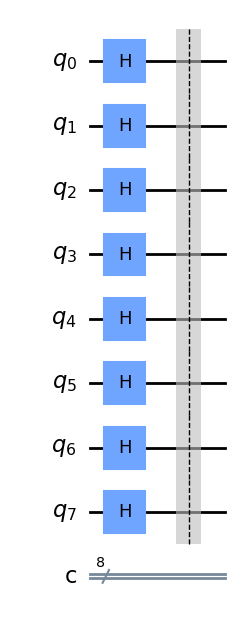

In [13]:
inputCircuit_8q = initCircuit(8)
inputCircuit_8q.draw(output='mpl')

## 8.2 create Oracle

In [14]:
def createOracle_255():
    circuit = QuantumCircuit(8, 8)
    
    circuit.h(7)
    circuit.mcx(list(range(7)), 7)
    circuit.h(7)
    circuit.barrier()
    
    return circuit

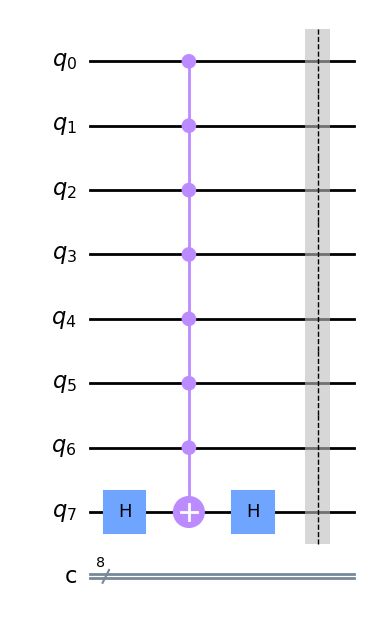

In [15]:
oracleCircuit_255 = createOracle_255()
oracleCircuit_255.draw(output='mpl')

### - test Oracle

In [217]:
Operator(oracleCircuit_255).data

array([[ 1.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  1.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  1.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       ...,
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  1.-9.71445147e-17j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  1.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        -1.-1.11022302e-16j]])

In [17]:
for index, row in enumerate(Operator(oracleCircuit_255).data):
    if abs(row[index] - -1) < 1e-6:
        print(index)

255


## 8.3 create diffuser

In [18]:
def createR_8q():
    circuit = QuantumCircuit(8, 8)
    
    circuit.x(7)
    circuit.x(6)
    circuit.x(5)
    circuit.x(4)
    circuit.x(3)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.h(7)
    circuit.mcx(list(range(7)), 7)
    circuit.barrier(0)
    circuit.barrier(1)
    circuit.barrier(2)
    circuit.barrier(3)
    circuit.barrier(4)
    circuit.barrier(5)
    circuit.barrier(6)
    circuit.h(7)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.x(5)
    circuit.x(4)
    circuit.x(3)
    circuit.x(7)
    circuit.x(6)
    
    return circuit

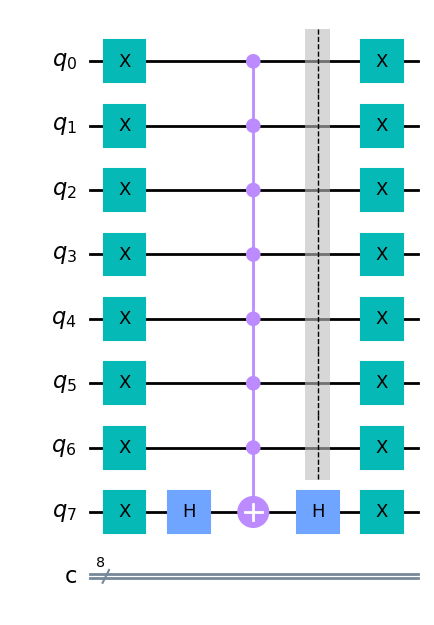

In [19]:
R_8q = createR_8q()
R_8q.draw(output='mpl')

In [20]:
def createDiffuser_8q():
    circuit = QuantumCircuit(8, 8)
    
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.h(4)
    circuit.h(5)
    circuit.h(6)
    circuit.h(7)
    circuit = circuit.compose(createR_8q())
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.h(4)
    circuit.h(5)
    circuit.h(6)
    circuit.h(7)
    circuit.barrier()
    
    return circuit

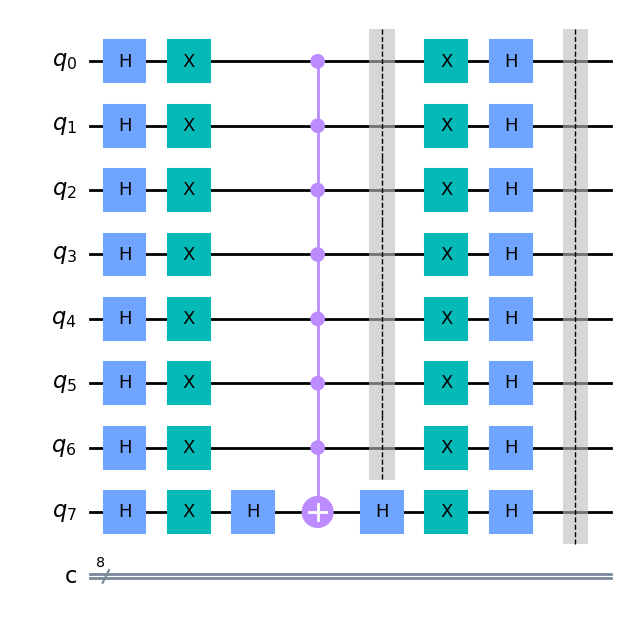

In [21]:
diffuserCircuit_8q = createDiffuser_8q()
diffuserCircuit_8q.draw(output='mpl')

## 8.4 Grover iteration

In [23]:
def createGroverIteration(oracle, diffuser):
    return oracle.compose(diffuser)

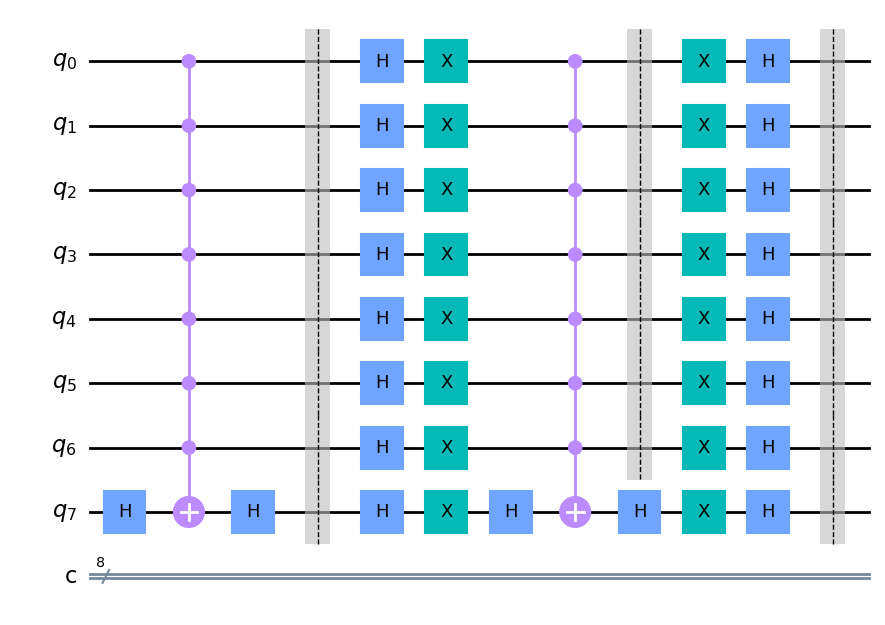

In [24]:
groverIteration_8q = createGroverIteration(createOracle_255(), createDiffuser_8q())
groverIteration_8q.draw(output='mpl')

## 8.5 measurements

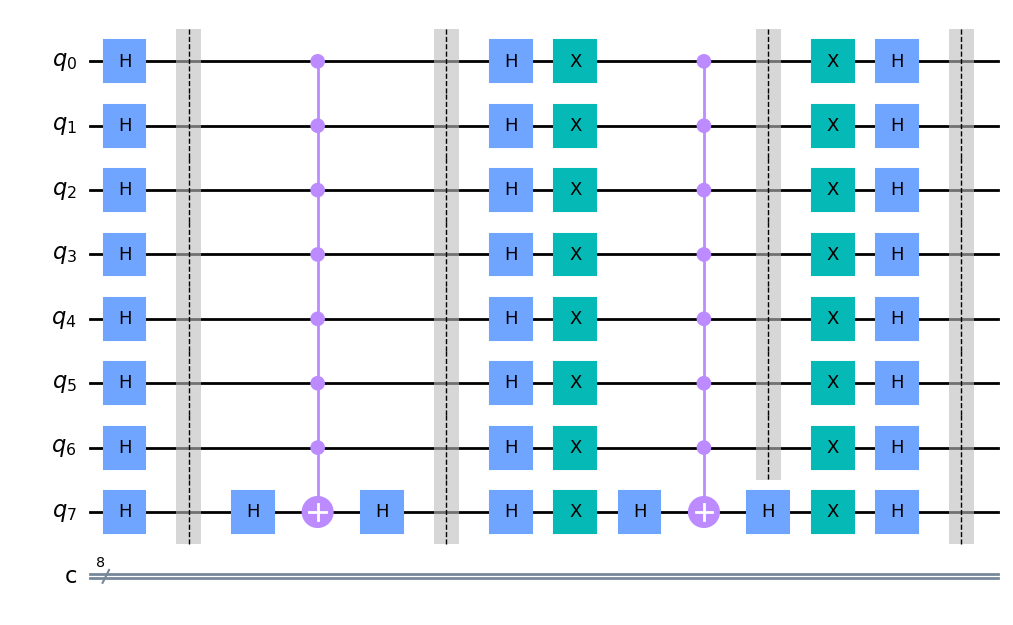

In [25]:
fullCircuit_8q = initCircuit(8).compose(groverIteration_8q)
fullCircuit_8q.draw(output='mpl')

### - theoretical calculation

In [27]:
import math

In [28]:
degree = math.degrees( math.asin(1 / np.sqrt(256)) )
degree

3.583321698471973

In [29]:
for k in range(1, 15):
    print(f'k = {k}: { math.sin(math.radians( (2 * k+1) * degree) ) ** 2 }')

k = 1: 0.0347909927368164
k = 2: 0.0946377220097929
k = 3: 0.17972062825725743
k = 4: 0.28474280203265145
k = 5: 0.4031659976541573
k = 6: 0.5276176773084243
k = 7: 0.650349994727914
k = 8: 0.7637221440185906
k = 9: 0.8606760445971724
k = 10: 0.9351757480633812
k = 11: 0.982583211354746
k = 12: 0.9999470421032736
k = 13: 0.9861862401036727
k = 14: 0.9421574959101175


### - measurement

In [30]:
def groverMeasurements(k):
    circuit = initCircuit(8)
    
    for i in range(k):
        circuit = circuit.compose(groverIteration_8q.copy())
    
    circuit.measure(list(range(8)), list(range(8)))
    
    job = execute(circuit, simulator, shots = 1)
    results = job.result()
    counts = results.get_counts(circuit)
    
    return list(counts)[0]

### - solutions finding algorithm

In [31]:
from random import randrange

def solutionFinding(limit):
    m = 1
    lam = 6 / 5
    count = 0 # iteration times
    
    while count <= limit * (9/4):
        if m > 1:
            j = randrange(0, math.floor(m))
            if j != 0:
                count += j
                answer = groverMeasurements(j)

                if answer == '11111111':
#                     print(f'Find! - total times: {count}')
                    return count, True
        m = min(lam * m, limit)
        
#     print(f'Not find! - total times: {count}')
    return count, False

In [32]:
times = 0
best = 1000
worst = 0
success = 0
for i in range(1000):
    time, flag = solutionFinding(np.sqrt(256)) # √N
    times += time
    best = min(best, time)
    worst = max(worst, time)
    if flag:
        success += 1
print(f'total test times: {1000}')
print('--------------------------')
print(f'Average run times: {times / 1000}')
print(f'best run times: {best}')
print(f'worst run times: {worst}')
print(f'Success rate: {success / 1000 * 100:.2f}%')

total test times: 1000
--------------------------
Average run times: 14.624
best run times: 1
worst run times: 51
Success rate: 99.80%
